# PINN for noisy aliased data

In this notebook, we will recreate the simple introductory physics-informed neural network (PINN) example from Chris Rackauckas's [SciML tutorial](https://book.sciml.ai/notes/03/) (with a bit more explanation and hopefully some notational clarity) that "learns" a spring-mass dynamics despite only given sparse data at inopportune intervals. We need the following Julia packages:

In [1]:
using Random, LinearAlgebra, DifferentialEquations, ApproxFun
using Plots, ChainPlots, LaTeXStrings, ProgressMeter

We also need to import the `Flux` package and functions:

In [2]:
using Flux
using Flux.Losses: mse
using Flux.Data: DataLoader
using Flux.Optimise: train!

Since the NN we will build is small, the GPU will not be helpful. So we will forgo importing the `CUDA` package for this problem.

## Underlying physics

Let's first define the problem. Imagine you are a "Physics 101" student tasked with a spring-mass lab assignment. You are given an object of mass $m=1$ on a "frictionless" surface attached to a spring with constant $k=1$ hooked up to a sensor to measure the force on the wall. The following image visualizes the configuration when the spring-mass is in equilibrium.

![img1](./figures/pinn_spring1.png)

Your task is to estimate the force on the wall at some arbitrary time $t$ with your knowledge of physics, namely Hooke's law $F_s(x) = -kx$, and compare it to empirical measurements from the lab.

A platonic spring-mass system then obeys the differential equation

$$
m\ddot x = -kx,\label{eq:linear}\tag{1}
$$

while in reality, there are imperfections in the spring as well as the unavoidable energy dissipation, which we simulate with the (unknown) ODE

$$
m\ddot x = \overbrace{-kx + \underbrace{0.1\sin(x)}_\text{imperfection}}^{\text{nonlinear }F(x)} - \underbrace{b\dot x}_\text{friction}.\label{eq:spring}\tag{2}
$$

In Julia's `DifferentialEquations` package, we define the "true" dynamics as a system of ODES:

In [25]:
function spring!(du,u,ℳ,t)
    x,ẋ = u

    du[1] = ∂ₜx = ẋ
    du[2] = ∂ₜẋ = (-ℳ.k*x + 0.1sin(x) - ℳ.b*ẋ)/ℳ.m
end

spring! (generic function with 1 method)

We will define the model parameters $\mathcal{M}$, including the *known* mass $m$ and spring constant $k$ as well as the *unknown* friction constant $b = 0.01$, the simulation time from $t=0$ to $t=15$, and the initial conditions reflecting the setup of an initially stretched spring with the *stationary* ($\dot x = 0$) mass let go from $x=0.5$.

In [76]:
m = 1.0    # known mass
k = 1.0    # known spring constant
b = 1e-2    # unknown friction constant
ℳ = (m=m,k=k,b=b)    # model parameters
t0,tf = 0.0,15.0    # time domain
x0,ẋ0 = 0.5,0.0    # initial conditions

(0.5, 0.0)

Let's "run" the experiment, that is, solve/simulate Eq. ([2](#mjx-eqn-eq:spring)):

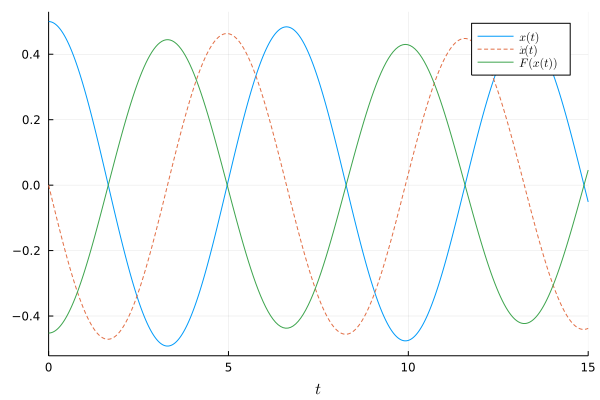

In [80]:
ode = ODEProblem(spring!,[x0,ẋ0],(t0,tf),ℳ)
u = solve(ode)

𝕋 = Chebyshev(t0..tf)
t = points(𝕋,length(u))
x = Fun(𝕋,ApproxFun.transform(𝕋,getindex.(u(t).u,1)))
F(x,ℳ) = -ℳ.k*x + 0.1sin(x)
Fx = F(x,ℳ)

fig = plot(u,style=[:solid :dash],xlabel=L"t",label=[L"x(t)" L"\dot x(t)"])
fig = plot!(Fx,label=L"F(x(t))")

In real life, we can approximately observe two of the three traces above by taking a very high quality video of the experiment, which gives us the displacement $x(t)$ as well as the force reading $F(t)$. (We can also approximate the velocity by using the displacements to compute central differences, but that's indirect.)

### Data generation

Unfortunately, you only have an old digital camera (remember those?) and need to take photos as the experiment progresses: You use the camera's "burst mode" and end up with $N=5$ photos at every $\Delta t = 3.3$ interval starting from $t = 1.7$. You notice that the photos of the moving mass is blurry and also remember that the displayed force is subject to machine error (although we assume it's still more precise than the locating the mass).

![img2](./figures/pinn_spring2.png)

We can simulate the sources of measurment error as random noise to get the data $x_i := x(t_i) + \xi^x_i$ (input) and $F_i := F(x(t_i)) + \xi^F_i$ (output), where $\xi^x_i\stackrel{\text{i.i.d.}}{\sim}\text{Normal}(0,0.01^2)$ and $\xi^F_i\stackrel{\text{i.i.d.}}{\sim}\text{Normal}(0,0.001^2)$.

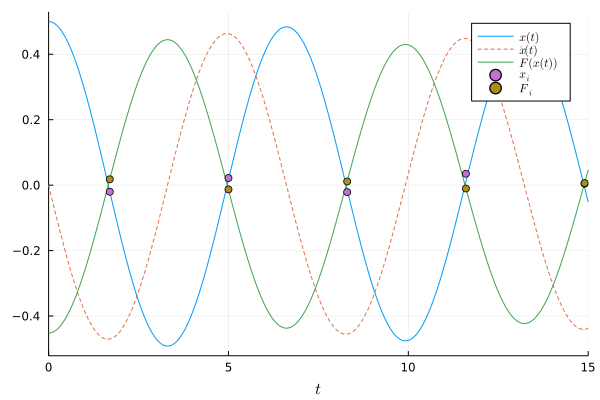

In [81]:
Random.seed!(1)
t̲ = 1.7:3.3:tf
N = length(t̲)
ξx = 0.01randn(N)
ξF = 0.001randn(N)
x̲ = x.(t̲) + ξx
F̲ = Fx.(t̲) + ξF

fig = plot(u,style=[:solid :dash],xlabel=L"t",label=[L"x(t)" L"\dot x(t)"])
fig = plot!(F(x,ℳ),label=L"F(x(t))")
fig = scatter!(t̲,x̲,label=L"x_i")
fig = scatter!(t̲,F̲,label=L"F_i")

## Model-driven estimation

You are now ready to finish your lab by predicting the displayed force $F(x)$ with your knowledge of the spring-mass dynamics and comparing it with the data collected above. Equation ([1](#mjx-eqn-eq:linear)) with the known mass and spring constant is a simple linear equation and can be solved exactly, but we will do so numerically:

In [15]:
function linear!(du,u,ℳ,t)
    x,ẋ = u

    du[1] = ∂ₜx = ẋ
    du[2] = ∂ₜẋ = -ℳ.k*x/ℳ.m
end

linear! (generic function with 1 method)

Before we compare our results with data, let's take a look at how different the traces look when we neglect friction and approximate the displayed spring force with $F(x) \approx F_s(x)$.

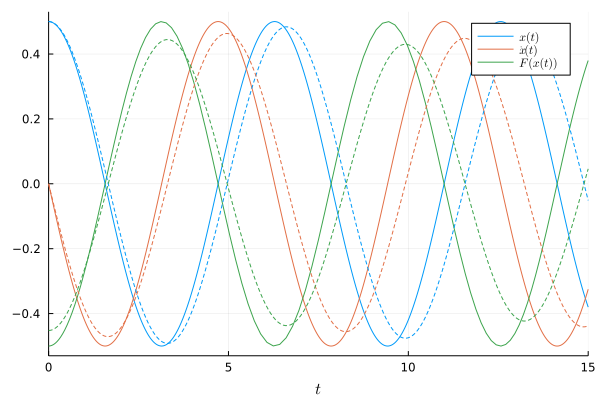

In [106]:
ū = solve(ODEProblem(linear!,[x0,ẋ0],(t0,tf),ℳ))
t = points(𝕋,length(ū))
x̄ = Fun(𝕋,ApproxFun.transform(𝕋,getindex.(ū(t).u,1)))

fig = plot(ū,label=[L"x(t)" L"\dot x(t)"])
fig = plot!(-k*x̄,label=L"F(x(t))")
color = palette(:default)
fig = plot!(u,style=:dash,color=color[1:2]',label=false)
fig = plot!(Fx,xlabel=L"t",style=:dash,color=color[3],label=false)

The physics *model* (solid lines) of Hooke's law performs well for the first half of the experiment, but diverges quite a bit from the true physical *reality* (dashed lines) of the dynamics in both phase and magnitude by the end. If we plot the predicted spring force with what was observed on the display in the sampled photos, this divergence is very clear.

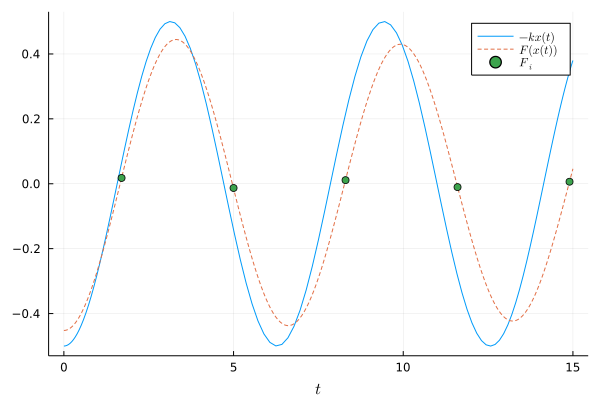

In [104]:
fig = plot(-k*x̄,xlabel=L"t",label=L"-kx(t)")
fig = plot!(Fx,style=:dash,label=L"F(x(t))")
fig = scatter!(t̲,F̲,label=L"F_i")

## Data-driven estimation

It's not terrible, but you remain motivated that you can do better. In fact, you're also enrolled in "Machine Learning 101"! You quickly identify the above as a simple supervised learning problem with a 1D input $x$ and 1D output/label $F(x)$ and come up with the MSE loss functional

$$
\mathcal{L}_1[\hat F] = \int_X \left| \hat F(x) - F(x) \right|^2 \,\text{d}\mu(x) \approx \frac{1}{N}\sum_{i=1}^N \left| \hat F(x_i) - F_i \right|^2,
$$

In [7]:
ℒ₁(f,x,y) = mse(f.(x),y)

ℒ₁ (generic function with 1 method)

and build a NN with one hidden layer of 32 neurons, as depicted below:

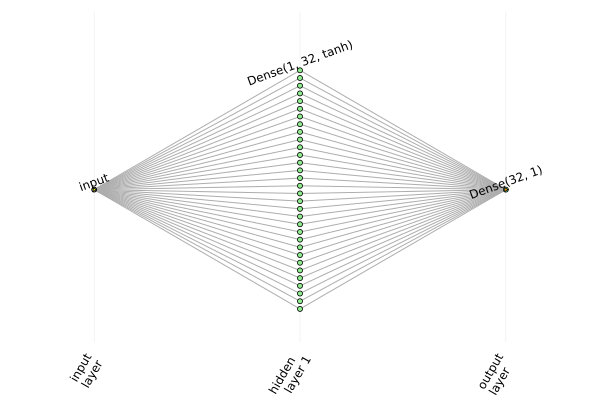

In [113]:
Random.seed!(2)
𝒩 = Chain(Dense(1,32,tanh),Dense(32,1))

fig = plot(𝒩)

(We'll marginally augment the NN to be able to use it as a scalar-valued function admitting scalar inputs.)

In [114]:
𝒩 = Chain(x->[x],𝒩...,y->y[1])
θ = params(𝒩)

Params([Float32[0.2525605; 0.3401842; … ; -0.23628105; 0.38598707;;], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.20599914 0.015782826 … -0.13090308 0.22580218], Float32[0.0]])

In [115]:
𝒟 = DataLoader((x̲,F̲),batchsize=N)

DataLoader{Tuple{Vector{Float64}, Vector{Float64}}, Random._GLOBAL_RNG}(([-0.020247003131753923, 0.021738192508921443, -0.021422374660318794, 0.034883113047794886, 0.00429926387477771], [0.01785474334992937, -0.01303122261165914, 0.011192485156789785, -0.010324650437183946, 0.006285401944916597]), 5, 5, true, 5, [1, 2, 3, 4, 5], false, Random._GLOBAL_RNG())

In [116]:
η = 0.01
𝒪 = Descent(η)

Descent(0.01)

In [117]:
Random.seed!(3)

M = 5000
pm = Progress(M)
for m ∈ 1:M
    train!((x,y)->ℒ₁(𝒩,x,y),θ,𝒟,𝒪)
    next!(pm)
end
F̂₁ = Chain(𝒩...)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Chain(
  var"#45#47"(),
  Dense(1, 32, tanh),                   # 64 parameters
  Dense(32, 1),                         # 33 parameters
  var"#46#48"(),
)                   # Total: 4 arrays, 97 parameters, 644 bytes.

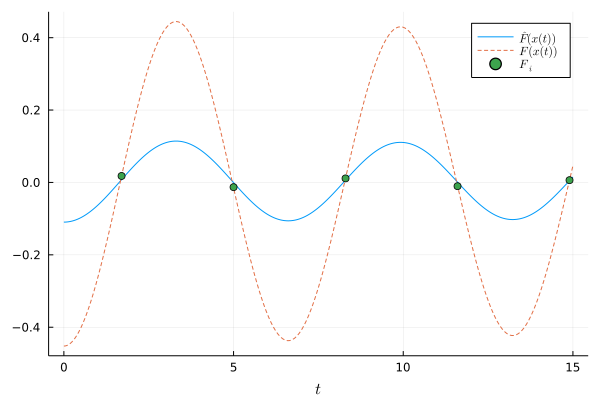

In [118]:
fig = plot(F̂₁(x),xlabel=L"t",label=L"\hat F(x(t))")
fig = plot!(Fx,style=:dash,label=L"F(x(t))")
fig = scatter!(t̲,F̲,label=L"F_i")

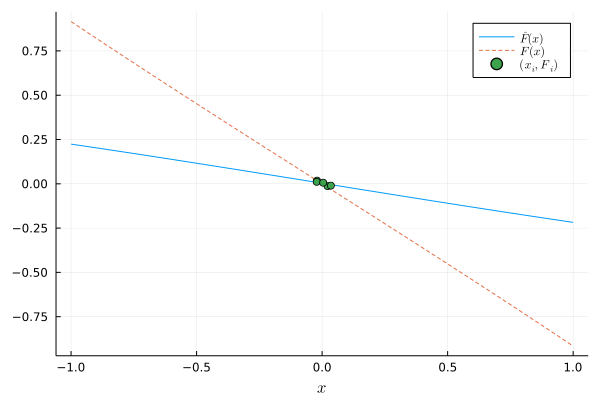

In [119]:
X = Fun(Chebyshev(-1..1))

fig = plot(F̂₁(X),xlabel=L"x",label=L"\hat F(x)")
fig = plot!(F(X,ℳ),style=:dash,label=L"F(x)")
fig = scatter!(x̲,F̲,label=L"(x_i,F_i)")

## Physics-informed estimation

In [17]:
ℒ₂(f,x,ℳ) = mse(f.(x),-ℳ.k*x)

ℒ₂ (generic function with 1 method)

In [18]:
ℒ(f,x,y,z,ℳ,λ) = ℒ₁(f,x,y) + λ*ℒ₂(f,z,ℳ)

ℒ (generic function with 1 method)

In [120]:
Random.seed!(4)
z = 2rand(100).-1
λ = 0.02

0.02

In [121]:
Random.seed!(5)

𝒩 = Chain(x->[x],Dense(1,32,tanh),Dense(32,1),y->y[1])
θ = params(𝒩)
pm = Progress(M)
for m ∈ 1:M
    train!((x,y)->ℒ(𝒩,x,y,z,ℳ,λ),θ,𝒟,𝒪)
    next!(pm)
end
F̂ = Chain(𝒩...)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


Chain(
  var"#51#53"(),
  Dense(1, 32, tanh),                   # 64 parameters
  Dense(32, 1),                         # 33 parameters
  var"#52#54"(),
)                   # Total: 4 arrays, 97 parameters, 644 bytes.

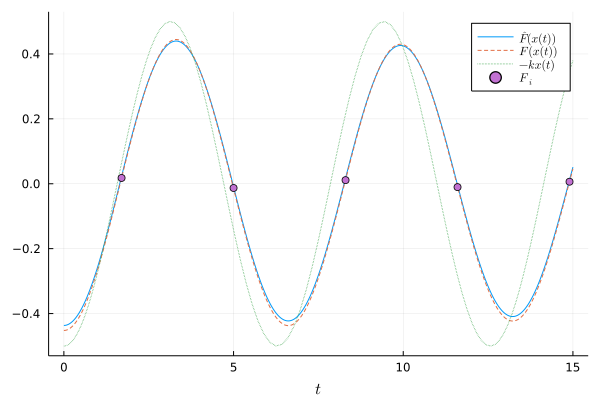

In [122]:
fig = plot(F̂(x),xlabel=L"t",label=L"\hat F(x(t))")
fig = plot!(Fx,style=:dash,label=L"F(x(t))")
fig = plot!(-k*x̄,style=:dot,label=L"-kx(t)")
fig = scatter!(t̲,F̲,label=L"F_i")

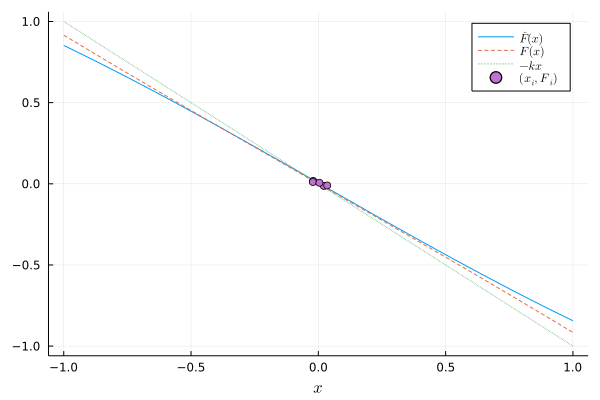

In [123]:
fig = plot(F̂(X),xlabel=L"x",label=L"\hat F(x)")
fig = plot!(F(X,ℳ),style=:dash,label=L"F(x)")
fig = plot!(-k*X,style=:dot,label=L"-kx")
fig = scatter!(x̲,F̲,label=L"(x_i,F_i)")